In [1]:
# Base libraries
import time
import datetime
import os
import math

# Scientific librariesz
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc


# Visual libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Helper libraries
import xlrd
import pprint
import base64

# Visual setup

# Pandas options
pd.options.display.max_columns = None

In [2]:
df_consolidado = pd.read_csv('data/2-plata/Consolidado_SIMAT_Depurado.csv',
                             index_col=0,
                             dtype={
                                 'ANO_INF':              'uint16',
                                 'CODIGO_DANE':          'uint64',
                                 'CODIGO_DANE_SEDE':     'uint64',
                                 'TIPO_DOCUMENTO':       'uint8',
                                 'NRO_DOCUMENTO':        'string',
                                 'DIRECCION_RESIDENCIA': 'string',
                                 'RES_DEPTO':            'uint8',
                                 'RES_MUN':              'uint16',
                                 'ESTRATO':              'uint8',
                                 'SISBEN':               'float16',
                                 'GENERO':               'string',
                                 'POB_VICT_CONF':        'uint8',
                                 'PROVIENE_SECTOR_PRIV': 'string',
                                 'PROVIENE_OTR_MUN':     'string',
                                 'TIPO_DISCAPACIDAD':    'uint8',
                                 'CAP_EXC':              'uint8',
                                 'CODIGO_ETNIA':         'uint16',
                                 'CODIGO_JORNADA':       'uint8',
                                 'CARACTER':             'uint8',
                                 'CODIGO_ESPECIALIDAD':  'uint8',
                                 'CODIGO_GRADO':         'int8',
                                 'CODIGO_METODOLOGIA':   'uint8',
                                 'REPITENTE':            'string',
                                 'SIT_ACAD_ANIO_ANT':    'uint8',
                                 'CON_ALUM_ANIO_ANT':    'uint8',
                                 'ZONA_RESI_ALU':        'uint8',
                                 'EDAD':                 'uint8',
                                 'NIVEL':                'uint8',
                                 'DIR_NUM_LOCALIDAD':    'uint8',
                                 'NIVEL_SISBEN':         'uint8'
                             },
                             # Descomentar la linea de abajo si quieren que se convierta
                             # la variable 'FECHA_NACIMIENTO' a datetime
                             # parse_dates=True
                            )

/opt/conda/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df_consolidado['INTERCEPTO'] = 1
df_consolidado['INTERCEPTO'] = df_consolidado['INTERCEPTO'].astype('uint8')
df_consolidado['REPITENTE'] = df_consolidado['REPITENTE'].replace({'S': 1, 'N': 0}).astype('uint8')
df_consolidado

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,ESTRATO,SISBEN,FECHA_NACIMIENTO,GENERO,POB_VICT_CONF,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CODIGO_ETNIA,CODIGO_JORNADA,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,CODIGO_METODOLOGIA,REPITENTE,SIT_ACAD_ANIO_ANT,CON_ALUM_ANIO_ANT,ZONA_RESI_ALU,EDAD,NIVEL,DIR_NUM_LOCALIDAD,NIVEL_SISBEN,INTERCEPTO
0,2017,111001000078,111001000078,2,00010803853,CL 69 A 105 F 67,11,1,2,0.010002,2000-01-08,F,9,N,N,99,9,0,6,1,5,10,1,0,1,9,1,17,4,16,1,1
1,2017,111001000078,111001014834,3,05057637,CL 34 SUR 40 A 51,11,1,3,NaN,2012-06-13,F,9,N,N,99,9,0,3,0,0,0,1,0,0,9,1,4,1,16,0,1
2,2017,111001000078,111001014834,3,067289989,KR 54 SUR 50 B 10,11,1,3,NaN,2008-10-07,M,9,N,N,7,9,0,3,0,0,3,1,0,1,9,1,8,2,16,0,1
3,2017,111001000078,111001014834,3,071759788,KR 40 28 A 02 SUR,11,1,3,NaN,2012-08-23,M,9,N,N,99,9,0,3,0,0,0,1,0,0,9,1,4,1,16,0,1
4,2017,111001000078,111001014834,3,089980482,KR 40 28 A 02 SUR,11,1,3,NaN,2013-11-16,F,9,N,N,99,9,0,3,0,0,-1,1,0,0,9,1,3,1,16,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4464566,2021,411102000293,411102000293,2,1012336508,KR 105 B 65 81 SUR,11,1,2,54.687500,2005-09-06,F,99,N,N,99,9,0,6,2,7,10,1,0,1,9,1,15,4,7,3,1
4464567,2021,411102000293,411102000293,2,1016713910,KR 99 A 71 39 SUR,11,1,2,61.218750,2005-10-01,F,99,N,N,99,9,0,6,2,7,10,1,0,1,9,1,15,4,7,3,1
4464568,2021,411102000293,411102000293,2,1011090034,CL 62 SUR 93 C 53,11,1,2,58.218750,2005-11-30,F,99,N,N,99,9,0,6,2,7,10,1,0,1,9,1,15,4,7,3,1
4464569,2021,411102000293,411102000293,2,1011092068,CL 61 B SUR 81 D 03,11,1,2,58.250000,2006-02-24,F,99,N,N,99,9,0,6,2,7,10,1,0,1,9,1,15,4,7,3,1


In [4]:
N = df_consolidado.shape[0] # Population size
CI = 0.997  # Confidence interval
Z = norm.ppf((1 + CI) / 2) # CI% significance interval two-tail test on a standard normal distribution 
p = df_consolidado[df_consolidado['REPITENTE'] == 1].shape[0] /  df_consolidado.shape[0] # Approximate proportion of the phenomenon under study to the reference population
q = 1 - p # Proportion of the reference population that does not present the phenomenon under study
d = 0.001 # Error

n = (N * (Z ** 2) * p * q) / ((d ** 2) * (N - 1) + (Z ** 2) * p * q) # Sample size for a finite population
n = int(math.ceil(n))
n 

203853

In [5]:
years = df_consolidado['ANO_INF'].unique().tolist()
options = df_consolidado['REPITENTE'].unique().tolist()

seed = 145
fractions= []
for year in years:
    fraction = df_consolidado[df_consolidado['ANO_INF'] == year]
    n_frac = math.ceil((fraction.shape[0] / df_consolidado.shape[0]) * n)
    n_frac = int(n_frac)
#     print(n_frac)
    fraction = fraction.sample(n=n_frac, random_state=seed)
    fractions.append(fraction)

df_consolidado_frac = pd.concat(fractions)
df_consolidado_frac

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,ESTRATO,SISBEN,FECHA_NACIMIENTO,GENERO,POB_VICT_CONF,PROVIENE_SECTOR_PRIV,PROVIENE_OTR_MUN,TIPO_DISCAPACIDAD,CAP_EXC,CODIGO_ETNIA,CODIGO_JORNADA,CARACTER,CODIGO_ESPECIALIDAD,CODIGO_GRADO,CODIGO_METODOLOGIA,REPITENTE,SIT_ACAD_ANIO_ANT,CON_ALUM_ANIO_ANT,ZONA_RESI_ALU,EDAD,NIVEL,DIR_NUM_LOCALIDAD,NIVEL_SISBEN,INTERCEPTO
362898,2017,111001041611,111001104175,5,1016725690,TV 4 C 50 C 29 SUR,11,1,0,21.921875,2011-08-05,M,9,N,N,99,9,0,2,0,0,0,1,0,1,9,1,5,1,18,1,1
557332,2017,111001104256,111001104256,2,1007135366,KR 128 144 28,11,1,3,0.010002,2002-07-05,M,9,N,N,99,9,0,3,0,0,9,1,0,1,9,1,14,3,11,1,1
164252,2017,111001014214,111001018279,2,1014872040,CL 40 SUR 21 35,11,1,3,NaN,2009-08-27,M,9,N,N,99,9,0,2,0,0,2,1,0,8,8,1,7,2,6,0,1
924198,2017,311001033463,311001033463,5,1023379816,KR 39 C 30 75 SUR,11,1,3,NaN,2008-05-16,F,9,N,N,99,9,0,1,0,0,4,1,0,1,9,1,8,2,15,0,1
71847,2017,111001011011,111001011011,2,1122839699,CL 48 SUR 29 80,11,1,2,25.890625,2006-02-10,M,9,N,N,99,9,0,2,0,0,6,1,0,1,9,1,11,3,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3940622,2021,111001025313,111001025313,5,1010215877,KR 19 A 12 45,11,1,2,0.000000,2012-05-28,F,99,S,N,99,9,0,6,0,0,3,1,0,1,9,1,9,2,14,1,1
3743164,2021,111001011053,111001011053,2,1013590836,KR 23 A 16 14 SUR,11,1,3,13.531250,2005-09-02,M,99,N,N,99,9,0,2,0,0,9,1,1,2,9,1,15,3,15,1,1
3959866,2021,111001027391,111001027391,5,1028898686,KR 93 C 61 B 67 SUR,11,1,2,0.000000,2016-10-02,F,99,N,N,99,9,0,3,0,0,-1,1,0,1,9,1,4,1,8,1,1
4082831,2021,111001075329,111001075329,5,1023404127,KR 18 ESTE 60 A 11 SUR,25,754,1,0.000000,2014-08-12,M,99,N,N,99,9,0,2,0,0,1,1,0,1,9,1,6,2,19,1,1


In [6]:
years = df_consolidado['ANO_INF'].unique().tolist()
per_original = df_consolidado[df_consolidado['REPITENTE'] == 1].shape[0] / df_consolidado.shape[0]
per_fraction = df_consolidado_frac[df_consolidado_frac['REPITENTE'] == 1].shape[0] / df_consolidado_frac.shape[0]
print(f'original: {per_original} - fraction: {per_fraction} ==> error: {per_original - per_fraction}')
for year in years:
    per_original = df_consolidado[(df_consolidado['ANO_INF'] == year) & (df_consolidado['REPITENTE'] == 1)].shape[0] / df_consolidado[df_consolidado['ANO_INF'] == year].shape[0]  
    per_fraction = df_consolidado_frac[(df_consolidado_frac['ANO_INF'] == year) & (df_consolidado_frac['REPITENTE'] == 1)].shape[0] / df_consolidado_frac[df_consolidado_frac['ANO_INF'] == year].shape[0] 
    print(f'original {year} : {per_original} - fraction {year}: {per_fraction} ==> error: {per_original - per_fraction}')

original: 0.02489124251570271 - fraction: 0.024816537163487952 ==> error: 7.470535221475866e-05
original 2017 : 0.008464341488807913 - fraction 2017: 0.008787510516967374 ==> error: -0.00032316902815946076
original 2018 : 0.01433381376903274 - fraction 2018: 0.014443858724301529 ==> error: -0.00011004495526878953
original 2019 : 0.03739717332957218 - fraction 2019: 0.036681665127089605 ==> error: 0.000715508202482576
original 2020 : 0.03911085777791781 - fraction 2020: 0.039596321214739834 ==> error: -0.0004854634368220215
original 2021 : 0.03837954964348135 - fraction 2021: 0.03758280383939435 ==> error: 0.0007967458040869999


In [7]:
df_consolidado_frac['REPITENTE'].value_counts() / df_consolidado_frac['REPITENTE'].shape[0]

0    0.975183
1    0.024817
Name: REPITENTE, dtype: float64

In [8]:
df_consolidado['REPITENTE'].value_counts() / df_consolidado['REPITENTE'].shape[0]

0    0.975109
1    0.024891
Name: REPITENTE, dtype: float64

In [9]:
# years = df_consolidado['ANO_INF'].unique().tolist()
# options = df_consolidado['REPITENTE'].unique().tolist()
# frac = 0.2
# seed = 145
# fractions= []
# for year in years:
#     for option in options:
#         fraction = df_consolidado[(df_consolidado['ANO_INF'] == year) & (df_consolidado['REPITENTE'] == option)]
#         fraction = fraction.sample(frac=frac, random_state=seed)
#         fractions.append(fraction)

# df_consolidado_frac = pd.concat(fractions)
# df_consolidado_frac

In [10]:
# del df_consolidado

In [11]:
categorias = [
#     'RES_DEPTO', # Muy grande
    'ESTRATO',
    'GENERO',
    'POB_VICT_CONF',
    'PROVIENE_SECTOR_PRIV',
    'PROVIENE_OTR_MUN',
    'TIPO_DISCAPACIDAD',
    'CAP_EXC',
    'CODIGO_ETNIA', # Muy largo
    'CODIGO_JORNADA',
    'CARACTER',
#     'CODIGO_ESPECIALIDAD', # Parecido a CARACTER
#     'CODIGO_GRADO',  # Parecido a NIVEL
    'CODIGO_METODOLOGIA',
    'SIT_ACAD_ANIO_ANT',
#     'CON_ALUM_ANIO_ANT',  # Arroja un probelma enternando el modelo
    'ZONA_RESI_ALU',
    'NIVEL',
    'DIR_NUM_LOCALIDAD',
    'NIVEL_SISBEN'
]

In [12]:
# df_consolidado_frac = df_consolidado_frac.astype({
#     'ANO_INF':              'uint16',
#     'CODIGO_DANE':          'uint64',
#     'CODIGO_DANE_SEDE':     'uint64',
#     'TIPO_DOCUMENTO':       'uint8',
#     'NRO_DOCUMENTO':        'string',
#     'DIRECCION_RESIDENCIA': 'string',
#     'RES_DEPTO':            'uint8',
#     'RES_MUN':              'uint16',
#     'ESTRATO':              'category',
#     'SISBEN':               'float16',
#     'GENERO':               'string',
#     'POB_VICT_CONF':        'category',
#     'PROVIENE_SECTOR_PRIV': 'category',
#     'PROVIENE_OTR_MUN':     'category',
#     'TIPO_DISCAPACIDAD':    'category',
#     'CAP_EXC':              'category',
#     'CODIGO_ETNIA':         'category',
#     'CODIGO_JORNADA':       'category',
#     'CARACTER':             'category',
#     'CODIGO_ESPECIALIDAD':  'uint8',
#     'CODIGO_GRADO':         'category',
#     'CODIGO_METODOLOGIA':   'category',
#     'REPITENTE':            'category',
#     'SIT_ACAD_ANIO_ANT':    'category',
#     'CON_ALUM_ANIO_ANT':    'category',
#     'ZONA_RESI_ALU':        'category',
#     'EDAD':                 'uint8',
#     'NIVEL':                'category',
#     'DIR_NUM_LOCALIDAD':    'category',
#     'NIVEL_SISBEN':         'category'    
# })

In [13]:
df_consolidado_frac = pd.get_dummies(
                                df_consolidado_frac,
                                columns=categorias,
                                prefix=categorias,
                                prefix_sep='_',
                                drop_first=True
                               )
df_consolidado_frac

,ANO_INF,CODIGO_DANE,CODIGO_DANE_SEDE,TIPO_DOCUMENTO,NRO_DOCUMENTO,DIRECCION_RESIDENCIA,RES_DEPTO,RES_MUN,SISBEN,FECHA_NACIMIENTO,CODIGO_ESPECIALIDAD,CODIGO_GRADO,REPITENTE,CON_ALUM_ANIO_ANT,EDAD,INTERCEPTO,ESTRATO_1,ESTRATO_2,ESTRATO_3,ESTRATO_4,ESTRATO_5,ESTRATO_6,GENERO_M,POB_VICT_CONF_2,POB_VICT_CONF_3,POB_VICT_CONF_4,POB_VICT_CONF_6,POB_VICT_CONF_9,POB_VICT_CONF_10,POB_VICT_CONF_15,POB_VICT_CONF_17,POB_VICT_CONF_18,POB_VICT_CONF_99,PROVIENE_SECTOR_PRIV_S,PROVIENE_OTR_MUN_S,TIPO_DISCAPACIDAD_3,TIPO_DISCAPACIDAD_4,TIPO_DISCAPACIDAD_6,TIPO_DISCAPACIDAD_7,TIPO_DISCAPACIDAD_8,TIPO_DISCAPACIDAD_9,TIPO_DISCAPACIDAD_10,TIPO_DISCAPACIDAD_11,TIPO_DISCAPACIDAD_12,TIPO_DISCAPACIDAD_13,TIPO_DISCAPACIDAD_14,TIPO_DISCAPACIDAD_15,TIPO_DISCAPACIDAD_17,TIPO_DISCAPACIDAD_18,TIPO_DISCAPACIDAD_19,TIPO_DISCAPACIDAD_99,CAP_EXC_2,CAP_EXC_3,CAP_EXC_4,CAP_EXC_5,CAP_EXC_6,CAP_EXC_7,CAP_EXC_9,CODIGO_ETNIA_1,CODIGO_ETNIA_2,CODIGO_ETNIA_3,CODIGO_ETNIA_4,CODIGO_ETNIA_5,CODIGO_ETNIA_6,CODIGO_ETNIA_8,CODIGO_ETNIA_9,CODIGO_ETNIA_10,CODIGO_ETNIA_12,CODIGO_ETNIA_14,CODIGO_ETNIA_15,CODIGO_ETNIA_16,CODIGO_ETNIA_17,CODIGO_ETNIA_19,CODIGO_ETNIA_20,CODIGO_ETNIA_22,CODIGO_ETNIA_23,CODIGO_ETNIA_25,CODIGO_ETNIA_26,CODIGO_ETNIA_27,CODIGO_ETNIA_28,CODIGO_ETNIA_29,CODIGO_ETNIA_31,CODIGO_ETNIA_33,CODIGO_ETNIA_34,CODIGO_ETNIA_35,CODIGO_ETNIA_36,CODIGO_ETNIA_40,CODIGO_ETNIA_42,CODIGO_ETNIA_43,CODIGO_ETNIA_45,CODIGO_ETNIA_46,CODIGO_ETNIA_47,CODIGO_ETNIA_48,CODIGO_ETNIA_49,CODIGO_ETNIA_50,CODIGO_ETNIA_51,CODIGO_ETNIA_54,CODIGO_ETNIA_57,CODIGO_ETNIA_58,CODIGO_ETNIA_64,CODIGO_ETNIA_65,CODIGO_ETNIA_66,CODIGO_ETNIA_67,CODIGO_ETNIA_72,CODIGO_ETNIA_73,CODIGO_ETNIA_74,CODIGO_ETNIA_75,CODIGO_ETNIA_77,CODIGO_ETNIA_82,CODIGO_ETNIA_83,CODIGO_ETNIA_85,CODIGO_ETNIA_86,CODIGO_ETNIA_95,CODIGO_ETNIA_96,CODIGO_ETNIA_97,CODIGO_ETNIA_98,CODIGO_ETNIA_99,CODIGO_ETNIA_101,CODIGO_ETNIA_102,CODIGO_ETNIA_107,CODIGO_ETNIA_200,CODIGO_ETNIA_400,CODIGO_ETNIA_998,CODIGO_ETNIA_999,CODIGO_JORNADA_2,CODIGO_JORNADA_3,CODIGO_JORNADA_4,CODIGO_JORNADA_5,CODIGO_JORNADA_6,CARACTER_1,CARACTER_2,CODIGO_METODOLOGIA_2,CODIGO_METODOLOGIA_9,CODIGO_METODOLOGIA_10,CODIGO_METODOLOGIA_11,CODIGO_METODOLOGIA_12,CODIGO_METODOLOGIA_20,SIT_ACAD_ANIO_ANT_1,SIT_ACAD_ANIO_ANT_2,SIT_ACAD_ANIO_ANT_8,ZONA_RESI_ALU_2,NIVEL_2,NIVEL_3,NIVEL_4,DIR_NUM_LOCALIDAD_2,DIR_NUM_LOCALIDAD_3,DIR_NUM_LOCALIDAD_4,DIR_NUM_LOCALIDAD_5,DIR_NUM_LOCALIDAD_6,DIR_NUM_LOCALIDAD_7,DIR_NUM_LOCALIDAD_8,DIR_NUM_LOCALIDAD_9,DIR_NUM_LOCALIDAD_10,DIR_NUM_LOCALIDAD_11,DIR_NUM_LOCALIDAD_12,DIR_NUM_LOCALIDAD_13,DIR_NUM_LOCALIDAD_14,DIR_NUM_LOCALIDAD_15,DIR_NUM_LOCALIDAD_16,DIR_NUM_LOCALIDAD_17,DIR_NUM_LOCALIDAD_18,DIR_NUM_LOCALIDAD_19,DIR_NUM_LOCALIDAD_20,NIVEL_SISBEN_1,NIVEL_SISBEN_2,NIVEL_SISBEN_3
362898,2017,111001041611,111001104175,5,1016725690,TV 4 C 50 C 29 SUR,11,1,21.921875,2011-08-05,0,0,0,9,5,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
557332,2017,111001104256,111001104256,2,1007135366,KR 128 144 28,11,1,0.010002,2002-07-05,0,9,0,9,14,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
164252,2017,111001014214,111001018279,2,1014872040,CL 40 SUR 21 35,11,1,NaN,2009-08-27,0,2,0,8,7,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
924198,2017,311001033463,311001033463,5,1023379816,KR 39 C 30 75 SUR,11,1,NaN,2

In [14]:
# df_consolidado_frac.columns[15:].tolist()

In [15]:
model_variables = df_consolidado_frac.columns[15:].tolist()
intercepto_idx = model_variables.index('INTERCEPTO')
model_variables_first = model_variables[0]
model_variables[intercepto_idx] = model_variables_first
model_variables[0] = 'INTERCEPTO'
# model_variables = model_variables[:model_variables.index('NIVEL_SISBEN_1')]
model_variables

['INTERCEPTO',
 'ESTRATO_1',
 'ESTRATO_2',
 'ESTRATO_3',
 'ESTRATO_4',
 'ESTRATO_5',
 'ESTRATO_6',
 'GENERO_M',
 'POB_VICT_CONF_2',
 'POB_VICT_CONF_3',
 'POB_VICT_CONF_4',
 'POB_VICT_CONF_6',
 'POB_VICT_CONF_9',
 'POB_VICT_CONF_10',
 'POB_VICT_CONF_15',
 'POB_VICT_CONF_17',
 'POB_VICT_CONF_18',
 'POB_VICT_CONF_99',
 'PROVIENE_SECTOR_PRIV_S',
 'PROVIENE_OTR_MUN_S',
 'TIPO_DISCAPACIDAD_3',
 'TIPO_DISCAPACIDAD_4',
 'TIPO_DISCAPACIDAD_6',
 'TIPO_DISCAPACIDAD_7',
 'TIPO_DISCAPACIDAD_8',
 'TIPO_DISCAPACIDAD_9',
 'TIPO_DISCAPACIDAD_10',
 'TIPO_DISCAPACIDAD_11',
 'TIPO_DISCAPACIDAD_12',
 'TIPO_DISCAPACIDAD_13',
 'TIPO_DISCAPACIDAD_14',
 'TIPO_DISCAPACIDAD_15',
 'TIPO_DISCAPACIDAD_17',
 'TIPO_DISCAPACIDAD_18',
 'TIPO_DISCAPACIDAD_19',
 'TIPO_DISCAPACIDAD_99',
 'CAP_EXC_2',
 'CAP_EXC_3',
 'CAP_EXC_4',
 'CAP_EXC_5',
 'CAP_EXC_6',
 'CAP_EXC_7',
 'CAP_EXC_9',
 'CODIGO_ETNIA_1',
 'CODIGO_ETNIA_2',
 'CODIGO_ETNIA_3',
 'CODIGO_ETNIA_4',
 'CODIGO_ETNIA_5',
 'CODIGO_ETNIA_6',
 'CODIGO_ETNIA_8',
 'CODIGO

In [16]:
model = sm.GLM(df_consolidado_frac['REPITENTE'], df_consolidado_frac[model_variables], family=sm.families.Binomial())

In [17]:
model_res = model.fit()

In [18]:
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              REPITENTE   No. Observations:               203856
Model:                            GLM   Df Residuals:                   203705
Model Family:                Binomial   Df Model:                          150
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18447.
Date:                Mon, 20 Jun 2022   Deviance:                       36893.
Time:                        21:04:31   Pearson chi2:                 2.17e+05
No. Iterations:                    25   Pseudo R-squ. (CS):            0.05019
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
INTERCEPTO               -28.6428   2.42e+05     -0.000      1.000   -4.75e+05    4.75e+05
ESTRATO_1                 -0.0750      0.062     -1.207      0.227      -0.197       0.047
ESTRATO_2                 -0.1074      0.055     -1.953      0.051      -0.215       0.000
ESTRATO_3                 -0.2459      0.067     -3.669      0.000      -0.377      -0.115
ESTRATO_4                 -0.5806      0.219     -2.651      0.008      -1.010      -0.151
ESTRATO_5                 -0.1449      0.402     -0.360      0.719      -0.933       0.643
ESTRATO_6                 -0.9073      0.731     -1.241      0.215      -2.340       0.526
GENERO_M                   0.1960      0.032      6.171      0.000       0.134       0.258
POB_VICT_CONF_2          -22.7882   5.49e+04     -0.000      1.000   -1.08e+05    1.08e+05
POB_VICT_CONF_3           -0.6477      0.821     -0.789      0.430      -2.256       0.961
POB_VICT_CONF_4           -0.4782      1.109     -0.431      0.666      -2.652       1.696
POB_VICT_CONF_6          -22.4175   2.51e+05  -8.92e-05      1.000   -4.93e+05    4.93e+05
POB_VICT_CONF_9           -0.7799      0.088     -8.849      0.000      -0.953      -0.607
POB_VICT_CONF_10          -0.2127      0.668     -0.318      0.750      -1.522       1.096
POB_VICT_CONF_15         -20.4223   2.51e+05  -8.13e-05      1.000   -4.92e+05    4.92e+05
POB_VICT_CONF_17         -22.2211   8.93e+04     -0.000      1.000   -1.75e+05    1.75e+05
POB_VICT_CONF_18         -22.1978   4.97e+04     -0.000      1.000   -9.74e+04    9.74e+04
POB_VICT_CONF_99           0.1874      0.083      2.255      0.024       0.025       0.350
PROVIENE_SECTOR_PRIV_S     0.1041      0.060      1.734      0.083      -0.014       0.222
PROVIENE_OTR_MUN_S        -0.1863      0.146     -1.277      0.202      -0.472       0.100
TIPO_DISCAPACIDAD_3       20.2193   2.42e+05   8.34e-05      1.000   -4.75e+05    4.75e+05
TIPO_DISCAPACIDAD_4       -0.9867   2.47e+05  -3.99e-06      1.000   -4.85e+05    4.85e+05
TIPO_DISCAPACIDAD_6       -0.7801    3.5e+05  -2.23e-06      1.000   -6.85e+05    6.85e+05
TIPO_DISCAPACIDAD_7       22.1078   2.42e+05   9.12e-05      1.000   -4.75e+05    4.75e+05
TIPO_DISCAPACIDAD_8       21.6724   2.42e+05   8.94e-05      1.000   -4.75e+05    4.75e+05
TIPO_DISCAPACIDAD_9        0.7346   2.75e+05   2.67e-06      1.000    -5.4e+05     5.4e+05
TIPO_DISCAPACIDAD_10      20.8685   2.42e+05   8.61e-05      1.000   -4.75e+05    4.75e+05
TIPO_DISCAPACIDAD_11      -1.2616   2.45e+05  -5.15e-06      1.000    -4.8e+05     4.8e+05
TIPO_DISCAPACIDAD_12      20.9643   2.42e+05   8.65e-05      1.000   -4.75e+05    4.75e+05
TIPO_DISCAPACIDAD_13      20.5301   2.42e+05   8.47e-05      1.000   -4.75e+05    4.75e+05
TIPO_DISCAPACIDAD_14      -2.9762   2.86e+05  -1.04e-05      1.000   -5.61e+05  

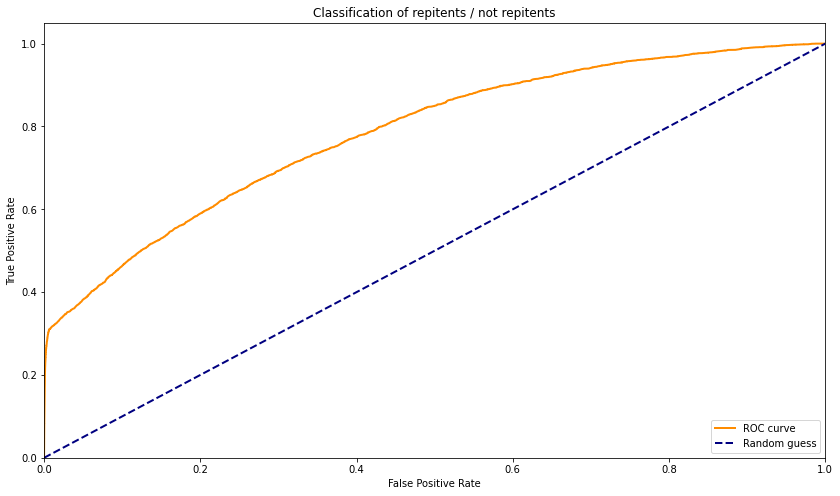

In [19]:
predict_p = model_res.predict(df_consolidado_frac[model_variables])
roc_p = roc_curve(df_consolidado_frac['REPITENTE'], predict_p)
plt.figure(figsize=(14,8))
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width, label=f'ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of repitents / not repitents')
plt.legend(loc='lower right')
plt.show()

In [20]:
# model = sm.Logit(df_consolidado_frac['REPITENTE'], df_consolidado_frac[model_variables])
# model_res = model.fit()
# model_res.summary()